In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df=pd.read_csv("PRC.csv",sep=';')
df.head(10)

,Date Made Public,Company,City,State,Type of breach,Type of organization,Total Records,Description of incident,Information Source,Source URL,Year of Breach,Latitude,Longitude,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,3/3/2006,PayDay OK LLC,NaN,New Jersey,HACK,BSF,88,The company's website was breached sometime ar...,California Attorney General,https://oag.ca.gov/,2006,40.058324,-74.405661,NaN,NaN,NaN
1,1/4/2012,"SF Fire Credit Union, Pacifica-Coastside Credi...",San Francisco,California,PORT,BSF,0,"The December 29, 2011 theft of a laptop from a...",California Attorney General,NaN,2012,37.774930,-122.419416,NaN,NaN,NaN
2,2/18/2012,"BDO USA, Rubio's Restaurants, Inc.",San Diego,California,PORT,BSR,0,BDO was contracted by Rubio's to perform finan...,California Attorney General,NaN,2012,32.715329,-117.157255,NaN,NaN,NaN
3,2/22/2012,"DHI Mortgage Company, Ltd.",Austin,Texas,HACK,BSF,0,"On February 10, 2012, DHI Mortgage became awar...",California Attorney General,NaN,2012,30.267153,-97.743061,NaN,NaN,NaN
4,3/12/2012,"Impairment Resources, LLC",San Diego,California,PORT,MED,"14,000",An office burglary on New Year's Eve 2011 resu...,California Attorney General,NaN,2012,32.715329,-117.157255,NaN,NaN,NaN
5,3/14/2012,"RJL Insurance Services, LLC, RJL Wealth Manage...",San Diego,California,DISC,BSF,0,RJL Insurance Services became aware of a vulne...,California Attorney General,NaN,2012,32.715329,-117.157255,NaN,NaN,NaN
6,3/19/2012,Kaiser Foundation Health Plan,Oakland,California,DISC,MED,"30,000",Someone purchased a hard drive in September of...,California Attorney General,NaN,2012,37.804364,-122.271114,NaN,NaN,NaN
7,3/19/2012,"IndyMac Bank, IndyMac Resources, Inc.",Dallas,Texas,DISC,BSF,0,A security company searching the web for sensi...,California Attorney General,NaN,2012,32.802955,-96.769923,NaN,NaN,NaN
8,3/23/2012,Manhattan Prep,New York,New York,HACK,BSR,0,"A hacker was able to access the names, mailing...",California Attorney General,NaN,2012,40.714353,-74.005973,NaN,NaN,NaN
9,3/31/2012,St. Joseph's Medical Center,Stockton,California,PHYS,MED,712,A storeroom window at Saint Joseph's HealthCar...,California Attorney General,NaN,2012,37.957702,-121.290780,NaN,NaN,NaN


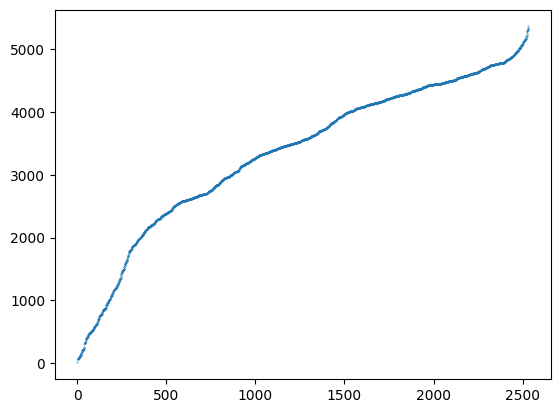

In [3]:
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']

dff=dff.apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x: x.days).sort_values()
l=np.asarray(dff)[1:]

plt.scatter(1+np.arange(len(l)), l,s=0.1)
plt.show()

In [14]:
def log_estimator_poisson(params):
 
    alpha, beta, gamma = params
    t_max = l[-1]
    log_like = (1-alpha)*t_max

    for i in range(len(l)):
        sum1 = np.sum(np.exp(-gamma*(l[i]*np.ones(i) - l[:i])))
        log_like += np.log(alpha + beta*sum1)
        log_like -= (beta/gamma) * (1-np.exp(-gamma*(t_max-l[i])))

    return -log_like

In [37]:
x0 = np.array([0.45, 1/2, 1])


bounds = ((0, None),(0, None), (0, None)) # I'll change this later maybe!

constr = [
    {'type':'ineq', 'fun' : lambda x: x[0]},
    {'type':'ineq', 'fun' : lambda x: x[1]},
    {'type':'ineq', 'fun' : lambda x: x[2]},
    {'type':'ineq', 'fun' : lambda x: x[2] - x[1]} ]

tmax = l[-1]
lik_model = sp.optimize.minimize(lambda x : log_estimator_poisson(x), x0, bounds=bounds, constraints= constr, method='SLSQP')

/tmp/ipykernel_2409/2956535199.py:9: RuntimeWarning: divide by zero encountered in log
  log_like += np.log(alpha + beta*sum1)


In [38]:
lik_model

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -9773.336517584572
       x: [ 2.723e-01  5.793e+03  2.085e+04]
     nit: 15
     jac: [-4.339e+02  2.515e-02  0.000e+00]
    nfev: 84
    njev: 15

In [39]:
print(f"alpha: {lik_model['x'][0]}, beta: {lik_model['x'][1]} and gamma: {lik_model['x'][2]}")

alpha: 0.2723462656762506, beta: 5793.393496349796 and gamma: 20854.059125092397


In [40]:
def estimate_poisson(params, dataset, t):
    timesteps = dataset[dataset <= t]
    y = params[0] * t
    temp = np.sum(1 - np.exp(-params[2] * (t - timesteps)))
    return y + (params[1] / params[2]) * temp

In [46]:
t = np.arange(len(l))
y = np.zeros(len(l))
for time in t: 
    result = estimate_poisson(lik_model['x'], l, time)
    y[time] = result

In [48]:
y = np.diff(y)

In [49]:
np.mean(y)

0.3335932176963052

In [50]:
x_vals = np.linspace(0, 10, 100)
density = sp.stats.expon.pdf(x_vals, scale=1)

[   8   57   60 ... 5321 5341 5364]


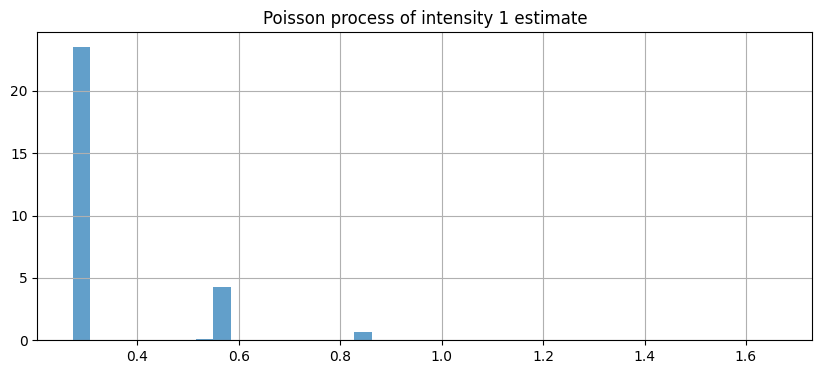

In [51]:
print(l)
plt.figure(figsize=(10, 4))
plt.hist(y, bins=40, density=True, alpha=0.7)
# plt.plot(x_vals, density)
plt.title("Poisson process of intensity 1 estimate")
plt.grid()
plt.show()